# Detecting Anomalies in Images

Anomaly detection involves identifying data points that deviate from the expected patterns of the majority. The goal is to differentiate between normal and anomalous items, framing the task as a binary classification problem. Traditional supervised learning techniques can address this issue, but they often struggle with highly imbalanced classes.

For example, in online financial transactions, millions of legitimate transactions occur daily, but only a small fraction may be fraudulent. A supervised learning approach would be challenged by the imbalance between the vast number of normal transactions and the few fraudulent ones. Autoencoders are particularly effective in this context, as they can be trained on legitimate transactions without requiring labeled data. Once trained, an autoencoder can analyze a transaction's feature representation, reconstruct it, and compare the output with the input. A significant difference between the input and output indicates a higher likelihood of fraud.

An autoencoder comprises two primary components: an encoder and a decoder. The encoder compresses the input data into a reduced representation, while the decoder attempts to reconstruct the original input from this compressed form. The network is designed to learn a compact representation of the training set, allowing for unsupervised anomaly detection. This makes autoencoders especially suitable for identifying anomalies without the need for extensive labeled datasets.

This notebook gives an example for an auto-encoder trained on [UCSD Anomaly Detection Dataset](http://www.svcl.ucsd.edu/projects/anomaly/dataset.htm)

*Let's start by importing necessary Libraries, downloading and extracting the dataset:*


In [1]:
import os
import numpy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
if torch.backends.mps.is_available():
   mps_device = torch.device("mps")
   x = torch.ones(1, device=mps_device)
   print (x)
else:
   print ("MPS device not found.")

tensor([1.], device='mps:0')


### Extracting the dataset

In [2]:
#!tar -xzvf "/content/drive/MyDrive/Anomaly Detection/UCSD_Anomaly_Dataset.tar.gz"

## Convolutional Autoencoders

In this section, we outline the architecture of the Convolutional Autoencoder. The encoder comprises two convolutional layers followed by two MaxPooling layers, while the encoder and decoder are linked through a fully connected layer. The size of this bottleneck layer influences the amount of information that can be reconstructed. The decoder consists of two Upsampling layers and two Deconvolution layers.

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png" alt="Autoencoder" width="500"/>

### Setting Up the UCSD Anomaly Detection Dataset and DataLoader

Here, we create a custom dataset class for the UCSD Anomaly Detection Dataset. We specify the dataset's path and apply necessary transformations, ultimately establishing a DataLoader to manage batching and shuffling for efficient training. The images from the UCSDped1 folder are originally sized at 158x238 pixels but are resized to 100x100 pixels and normalized for processing.

In [3]:
import glob
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class UCSDAnomalyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = sorted(glob.glob(self.root_dir + '/*/*'))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filename = self.files[idx]
        image = Image.open(filename)
        if self.transform:
            image = self.transform(image)
        return image

# Define the path to the dataset UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train
dataset_path = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train'

# Define the transformation to resize images to 100x100 and convert to tensor
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Create an instance of the UCSDAnomalyDataset
ucsd_dataset = UCSDAnomalyDataset(root_dir=dataset_path, transform=transform)

# Define batch size
batch_size = 32

# Create DataLoader
dataloader = DataLoader(ucsd_dataset, batch_size=batch_size, shuffle=True)

print("Dataset Loaded Successfully!!")


Dataset Loaded Successfully!!


/Users/priyanshukumarsaw/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Building the Convolutional Autoencoder Model

In this section, we construct a convolutional autoencoder using PyTorch. Autoencoders are neural networks designed to learn efficient representations of input data in an unsupervised manner. This model comprises both encoder and decoder layers, which work together to generate a compact representation of input images and subsequently reconstruct them.

#### Architecture Overview

The autoencoder consists of two primary components: the encoder and the decoder.

#### Encoder: 
The encoder compresses the input image into a lower-dimensional representation through:
- Convolutional layers that extract essential features from the image.
- Max pooling layers that reduce the spatial dimensions of the feature maps.

#### Decoder: 
The decoder reconstructs the image from the compressed representation, incorporating:
- Fully connected layers that expand the compressed data back to the original image dimensions.
- Transposed convolutional layers that increase the spatial dimensions to reconstruct the original image effectively.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        # Encoder Layers
        self.encoder_conv1 = nn.Conv2d(1, 32, 5, stride=1, padding=2)  # Changed kernel size to (5, 5) and output channels to 32
        self.encoder_pool1 = nn.MaxPool2d(2, 2)
        self.encoder_conv2 = nn.Conv2d(32, 16, 3, stride=1, padding=1)  # Adjusted input channels to 32
        self.encoder_pool2 = nn.MaxPool2d(2, 2)
        # Bottleneck Layer
        self.bottleneck = nn.Linear(16*25*25, 4500)  # Adjusted input size based on the changes in encoder layers
        # Decoder Layers
        self.decoder_linear = nn.Linear(4500, 16*25*25)
        self.decoder_conv1 = nn.ConvTranspose2d(16, 32, 3, stride=2, padding=1, output_padding=1)  # Adjusted input and output channels
        self.decoder_conv2 = nn.ConvTranspose2d(32, 1, 5, stride=2, padding=2, output_padding=1)  # Changed kernel size to (5, 5) and adjusted input and output channels

    def forward(self, x):
        # Encoder
        x = F.relu(self.encoder_conv1(x))
        x = self.encoder_pool1(x)
        x = F.relu(self.encoder_conv2(x))
        x = self.encoder_pool2(x)

        # Flatten for fully connected layer
        x = x.view(-1, 16*25*25)
        # Bottleneck Layer
        x = F.relu(self.bottleneck(x))
        # Decoder
        x = F.relu(self.decoder_linear(x))
        x = x.view(-1, 16, 25, 25)  # Adjusted input channels for decoder ConvTranspose2d
        x = F.relu(self.decoder_conv1(x))
        x = torch.sigmoid(self.decoder_conv2(x))  # Using sigmoid activation for reconstruction
        return x

# Create an instance of the ConvAutoEncoder model
model = ConvAutoEncoder()
print(model)


ConvAutoEncoder(
  (encoder_conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (encoder_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Linear(in_features=10000, out_features=4500, bias=True)
  (decoder_linear): Linear(in_features=4500, out_features=10000, bias=True)
  (decoder_conv1): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (decoder_conv2): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
)


### Training the Convolutional Autoencoder

In this section, we outline the training procedure for the convolutional autoencoder model using the UCSD Anomaly Detection Dataset. We begin by defining the model architecture, loss function, optimizer, and learning rate scheduler, and then we configure the model to run on the appropriate device (CPU or GPU). 

The training process involves iterating over the dataset for a predetermined number of epochs, during which the model's parameters are adjusted to reduce the reconstruction loss. This comprehensive training workflow includes model initialization, loss computation, optimizer configuration, device setup, and the execution of the training loop. Through this iterative process, the model parameters are refined to minimize the reconstruction loss, ultimately producing a trained autoencoder capable of effectively encoding and decoding images.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define your autoencoder model (ConvAutoEncoder)
model = ConvAutoEncoder()


# Define loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define optimizer (e.g., Adam) with learning rate decay
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Set device (CPU or GPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print("Using MPS device:")
    print(x)
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU:")
    x = torch.ones(1, device=device)
    print(x)

# Move model to device
model.to(device)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, inputs in enumerate(dataloader):
        inputs = inputs.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(ucsd_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Step the scheduler
    scheduler.step()

print("Training complete!")


Using MPS device:
tensor([1.], device='mps:0')
Epoch [1/15], Loss: 0.0061
Epoch [2/15], Loss: 0.0033
Epoch [3/15], Loss: 0.0026
Epoch [4/15], Loss: 0.0022
Epoch [5/15], Loss: 0.0020
Epoch [6/15], Loss: 0.0018
Epoch [7/15], Loss: 0.0017
Epoch [8/15], Loss: 0.0017
Epoch [9/15], Loss: 0.0016
Epoch [10/15], Loss: 0.0015
Epoch [11/15], Loss: 0.0015
Epoch [12/15], Loss: 0.0015
Epoch [13/15], Loss: 0.0014
Epoch [14/15], Loss: 0.0014
Epoch [15/15], Loss: 0.0014
Training complete!


### Saving and Loading Model Parameters

In this section, we cover the process of saving and loading the parameters of the convolutional autoencoder model using PyTorch. This functionality allows you to preserve the trained model's state and easily reload it for future use, facilitating model evaluation or further training without starting from scratch.

In [6]:
# Save model parameters
torch.save(model.state_dict(), 'new_autoencoder_model2.pth')
# Load Model Parameters
model = ConvAutoEncoder()


model.load_state_dict(torch.load('new_autoencoder_model2.pth'))

model.eval()

ConvAutoEncoder(
  (encoder_conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (encoder_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Linear(in_features=10000, out_features=4500, bias=True)
  (decoder_linear): Linear(in_features=4500, out_features=10000, bias=True)
  (decoder_conv1): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (decoder_conv2): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
)

### Creating the UCSD Anomaly Test Dataset and DataLoader

In this section, we describe how to set up a test dataset and DataLoader for assessing the convolutional autoencoder model's performance on new, unseen data from the UCSD Anomaly Detection Dataset. This process is essential for evaluating the model's effectiveness in detecting anomalies in real-world scenarios.

In [10]:
import glob
from PIL import Image
import torch 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class UCSDAnomalyTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = sorted(glob.glob(self.root_dir + '/*'))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filename = self.files[idx]
        image = Image.open(filename)
        if self.transform:
            image = self.transform(image)
        return image

# Define the path to the test dataset
test_dataset_path = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024'

# Define the transformation for the test dataset
test_transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize images to 100x100
    transforms.ToTensor()            # Convert images to tensors
])

# Create an instance of the UCSDAnomalyTestDataset with the transformation
test_dataset = UCSDAnomalyTestDataset(root_dir=test_dataset_path, transform=test_transform)

# Define batch size for the test DataLoader
test_batch_size = 1  # You can adjust this as needed

# Create DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

print("Test DataLoader created successfully!")


Test DataLoader created successfully!


Just Checking the output of the image of one of the images From test dataset.

Shape of the first image: torch.Size([1, 100, 100])


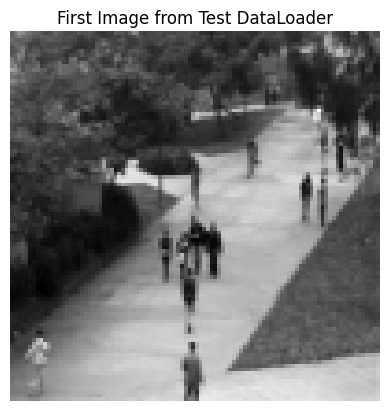

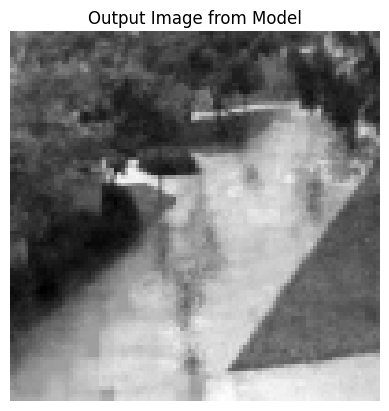

In [11]:
# Get the first batch from the test DataLoader
first_batch = next(iter(test_dataloader))

# Access the first image within the batch
first_image = first_batch[0]

# Print the shape of the first image
print("Shape of the first image:", first_image.shape)

# Optionally, you can convert the tensor to a numpy array for visualization
first_image_numpy = first_image.squeeze().cpu().numpy()

plt.imshow(first_image_numpy, cmap='gray')
plt.title('First Image from Test DataLoader')
plt.axis('off')  # Turn off axis
plt.show()

# Forward pass to obtain the output image from the model
output_image = model(first_image.unsqueeze(0))  # Forward pass with the first image

# Convert the output tensor to a numpy array and squeeze it to remove any singleton dimensions
output_image_numpy = output_image.squeeze().cpu().detach().numpy()

# Plot the output image
plt.imshow(output_image_numpy, cmap='gray')
plt.title('Output Image from Model')
plt.axis('off')  # Turn off axis
plt.show()
# Now, you can visualize or process the first image as needed


A helper function that will plot input and output images and the differnce between them.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot(img, output, diff, H, threshold, counter):
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(10, 5))
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()

    ax0.set_title('Input image')
    ax1.set_title('Reconstructed image')
    ax2.set_title('Difference')
    ax3.set_title('Anomalies')

    ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    ax1.imshow(output, cmap=plt.cm.gray, interpolation='nearest')
    ax2.imshow(diff, cmap=plt.cm.viridis, vmin=0, vmax=255, interpolation='nearest')
    ax3.imshow(img, cmap=plt.cm.gray, interpolation='nearest')

    x, y = np.where(H > threshold)
    ax3.scatter(y, x, edgecolor='red',facecolors = 'none',  s=200, marker = 's')

    plt.axis('off')

    fig.savefig(f'/Users/priyanshukumarsaw/Downloads/Anomaly Detction Project/img/{counter}.png')
    plt.close(fig)


This goes iteratively to every image present in test024 folder and plots the data and save it in specified folder

In [14]:
import torch
import torch.nn.functional as F
import numpy as np

# Define the threshold for anomaly detection
threshold = 6 * 255  # Adjust as needed

# Define the convolution kernel
kernel_size = 4  # Size of the kernel for convolution
kernel = torch.ones(1, 1, kernel_size, kernel_size).to(device)  # Define a kernel of ones
counter = 0
# Iterate over the images in the test DataLoader
for batch_idx, inputs in enumerate(test_dataloader):
    # Transfer the input images to the device (GPU if available)
    #inputs = inputs.to(device)

    # Forward pass to obtain the output images from the model
    outputs = model(inputs)

    # Convert tensors to numpy arrays for visualization
    input_images = inputs.cpu().numpy() * 255.0  # Convert to numpy and scale to [0, 255]
    output_images = outputs.cpu().detach().numpy() * 255.0  # Convert to numpy and scale to [0, 255]

    # Compute the absolute differences between input and output images
    differences = np.abs(output_images - input_images)

    # Perform convolution on the differences using the defined kernel
    H = F.conv2d(torch.tensor(differences).to(device), kernel, padding=kernel_size // 2)[0, 0].cpu().numpy()

    # Detect anomalies based on the processed differences (H) and the threshold
    anomalies = H > threshold

    # Now, you can use the plot function to visualize the input images, output images, differences,
    # and anomalies for each image in the batch
    for i in range(len(input_images)):
        plot(input_images[i, 0], output_images[i, 0], differences[i, 0], H, threshold, counter)
        counter+=1


Now For Better Visualisaton, Taking all the images and making a Animation out of it.

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


ffmpeg not available, using imagemagick instead
Video created successfully!


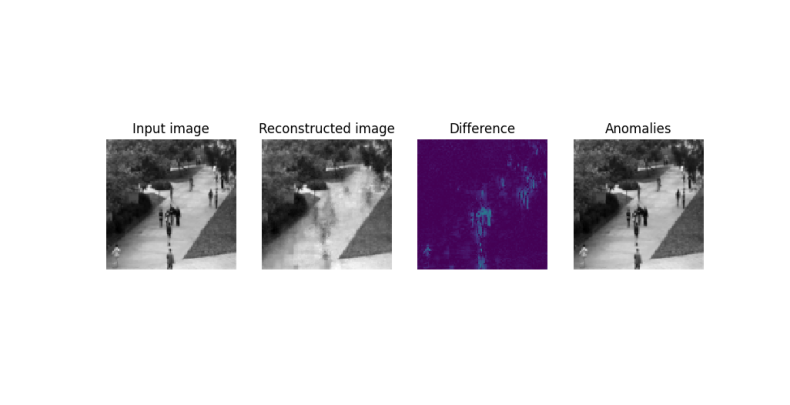

In [19]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Folder containing the PNG images
folder_path = "/Users/priyanshukumarsaw/Downloads/Anomaly Detction Project/img/"

# Output video file path
output_path = "/Users/priyanshukumarsaw/Downloads/Anomaly Detction Project/output1.mp4"

# List all the PNG files in the folder
file_names = [f"{folder_path}/{i}.png" for i in range(200)]

# Function to update the plot for each frame of the animation
def update(frame):
    img = plt.imread(file_names[frame])
    im.set_array(img)
    return [im]

# Load the first image to get its size
img = plt.imread(file_names[0])
height, width, _ = img.shape

# Create a figure with the size of the first image
fig = plt.figure(figsize=(width/100, height/100))
ax = plt.axes()
ax.axis('off')

# Display the first image
im = ax.imshow(img)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(file_names), interval=50)

# Save the animation as a video
try:
    ani.save(output_path, writer='ffmpeg', fps=30)  # Adjust fps as needed
except ValueError:
    print("ffmpeg not available, using imagemagick instead")
    output_path = output_path.replace('.mp4', '.gif')
    ani.save(output_path, writer='imagemagick', fps=30)

print("Video created successfully!")


### Conclusion

In this notebook, we successfully developed an anomaly detection system utilizing a Convolutional Autoencoder (CAE) with the UCSD dataset. This dataset includes video sequences featuring both normal and abnormal activities, making it an excellent candidate for anomaly detection applications.

We started by preparing the dataset and creating a custom Dataset class to handle image loading and preprocessing. Subsequently, we designed the architecture of the Convolutional Autoencoder, which consists of encoder and decoder layers. The encoder focuses on extracting significant features from the input images, while the decoder is responsible for reconstructing these images from the encoded data.

During the training process, we employed Mean Squared Error (MSE) loss to evaluate the discrepancies between the input and output images. The Adam optimizer, complemented by a learning rate scheduler, facilitated efficient model training.

Upon completion of training, we assessed the model's performance on the test dataset. We visualized the reconstructed images and calculated the differences between the original and reconstructed images, identifying anomalies by comparing these differences to a set threshold.

Finally, we created a video that summarized the anomaly detection workflow, displaying the input images, their reconstructions, the differences, and the detected anomalies.

Overall, this notebook showcases the capability of Convolutional Autoencoders in tackling anomaly detection challenges, particularly with the UCSD dataset. Future efforts could focus on refining the model architecture and investigating advanced techniques to further enhance detection accuracy.